<font size="4">**Proyecto Final**</font>

**Modulo 5:** Inteligencia de Negocios  
**Alumno:** Luis Esquivel Quesada  
**Prof.** Cristian Campos Agüero

Tecnológico de Costa Rica  
22 de setiembre de 2022

**Fase 1: Entendimiento del negocio**

***Contexto***

Este proyecto esta basado en un pipeline creado hace algun tiempo para extraer informacion de anuncios de vehiculos usados en las paginas de crautos.com y purdyusados.com utilizando un framework conocido como Scrappy, el cual facilita la estructura de un proyecto de extraccion a mayor escala. Para accesar al codigo, pueden seguir el link a mi repositorio https://github.com/lalejandroeq/scrappy_vehicles

***Objetivos de negocio***

La información disponible en los sitios web anteriormente descritos, no está necesariamente en condiciones óptimas, muchas veces, esta información puede presentar datos faltantes que impiden el registro correcto de todos los valores que describen un anuncio.

Para poder utilizar esta información para análisis y post procesamiento después de su captura, es necesario completar la información lo mejor posible, y el negocio ha notado que muchos de los anuncios les hace falta la marca del carro, por lo que el objetivo principal del negocio es de alguna manera, completar la información de las marcas de los vehículos. 

***Criterios de éxito***

El éxito está definido como la capacidad de completar los datos faltantes de la manera más integra posible, de manera que las técnicas que se utilicen para determinar las marcas de carros faltantes en el conjunto de datos deben tener un grado de precisión mejor que el simplemente sustituir la marca con un valor como la moda del conjunto de datos.
Adicionalmente, el segundo criterio de éxito es poder utilizar la información que está actualmente almacenada como imágenes de los autos, de manera que las técnicas que se implementen para el proyecto deberán de utilizar las imágenes como parte de los criterios de imputación de las marcas faltantes.


***Objetivos de minería de datos***

• Implementar un modelo de aprendizaje profundo que pueda procesar las imágenes que se almacenan para cada anuncio de carro

***Criterios de éxito (minería de datos)***

• Un modelo de clasificación con mejor precisión que el etiquetado de un modelo ingenuo (digamos etiquetar todos los faltantes con la moda del conjunto de datos)  
• Capacidad de crear una red neuronal de aprendizaje profundo que pueda predecir las marcas de carros mediante las matrices de pixeles de las imágenes de estos.


**Fase 2: Entendimiento de los datos**

Librerias a utilizar

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os.path import exists
import tensorflow as tf
import cv2
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.data import AUTOTUNE

**Declaracion de los parametros de ejecucion**

In [2]:
# Declare execution parameters
DB_PATH = "cars.db"
IMAGE_SIZE = 200
IMAGES_FOLDER = r"C:\Users\lalej\OneDrive\Documents\Isolation\Documents\Aragnas\engine\images"
MODELS = ['Toyota YARIS', 'Hyundai ACCENT', 'Honda CIVIC', 'Nissan XTRAIL']
TEST_SIZE = 0.1

In [3]:
def execute(connection, query):
    # Abrir cursor con la conexion a la base de datos
    cursor = connection.cursor()
    # Ejecutar la consulta con el cursor
    cursor.execute(query)
    # Obtener los nombres de columnas del cursor despues de ejecutar la consulta
    headers = list(map(lambda x: x[0], cursor.description))
    # Obtener todos los resultados desde el cursor
    results = cursor.fetchall()
    cursor.close() # Cerrar el cursor
    return headers, results

def get_valid_cars_from_db(connection, brands, images_folder):
    # Concatenar y formatear las marcas a buscar en un solo string para el query
    brands_search = ""
    for i, brand in enumerate(brands):
        comma = ", "
        if i == 0:
            comma = ""
        brands_search += "{}'{}'".format(comma, brand)
    # Formulacion de la consulta que utilizando el folder de las imagenes, utiliza el nombre del archivo de la base de datos
    # y el folder (car_id y crawler_id respectivamente) genera el path a donde se encuentra la imagen en el disco local
    query = """
            SELECT '{}'||'\\'||crawler_id||'\\'||'full\\'||car_id||'.jpg' as path, brand || ' ' || model_split0 as label
            FROM cars_clean_tb WHERE brand || ' ' || model_split0 IN ({});
            """.format(images_folder, brands_search)
    column_names, query_results = execute(connection, query)
    return column_names, [car for car in query_results if exists(car[0])]  # Validar que el path de la imagen exista, de lo contrario, no se almacena

def get_image(file_path, image_size):
    # Cargar la imagen como texto (pixeles)
    image = tf.io.read_file(file_path)
    # Convertir el texto a un tensor de numeros enteros con 3 canales (RGB)
    decoded_image = tf.io.decode_jpeg(image, channels=3)
    # Alterar el tamaño de la imagen al deseado
    resized_image = tf.image.resize(decoded_image, [image_size, image_size])
    return resized_image

Descripcion del flujo de procesamiento:
- Leer los paths y marcas (etiquetas) de la base de datos
- Descriptivos del conjunto de datos
- Limpiar las imagenes
- Hacer la separacion entre el entrenamiento y el test
- Leer las imagenes a partir de los paths
- Definir la arquitectura de la red neuronal
- Ejecutar la red y guardar los resultados en un archivo csv

In [4]:
# Crear la conexion a la base de datos
con = sqlite3.connect(DB_PATH)

**Lectura del conjunto de datos**

La data original se encuentra almacenada en un archivo de SQLite

In [5]:
column_names, valid_cars = get_valid_cars_from_db(con, MODELS, IMAGES_FOLDER)
df = pd.DataFrame(valid_cars, columns=column_names)
# Barajar los datos para eliminar ordenamiento
df = df.sample(frac=1).reset_index(drop=True)
# Mostrar el conjunto de datos
df

,path,label
0,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Hyundai ACCENT
1,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Nissan XTRAIL
2,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS
3,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS
4,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Honda CIVIC
...,...,...
1102,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS
1103,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS
1104,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS
1105,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS


**Conteos por marca**

In [6]:
agg_df = df.groupby(['label'])['label'].count()
agg_df

label
Honda CIVIC       184
Hyundai ACCENT    336
Nissan XTRAIL     188
Toyota YARIS      399
Name: label, dtype: int64

In [7]:
classes = sum([1 for v in agg_df.index])
classes

4

In [8]:
print("Nulos en los paths:")
print(df['path'].isna().sum())
print("Nulos en las etiquetas:")
print(df['label'].isna().sum())

Nulos en los paths:
0
Nulos en las etiquetas:
0


**Categorizacion de las etiquetas**

In [9]:
# Categorizar la variable de etiquetas
df["label"] = df["label"].astype('category')
df["y"] = df["label"].cat.codes
df

,path,label,y
0,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Hyundai ACCENT,1
1,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Nissan XTRAIL,2
2,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3
3,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3
4,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Honda CIVIC,0
...,...,...,...
1102,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3
1103,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3
1104,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3
1105,C:\Users\lalej\OneDrive\Documents\Isolation\Do...,Toyota YARIS,3


**Lectura de las imagenes**

Utilizando los datasets de entrenamiento y pruebas ya separados, se procede a leer el path que contiene el conjunto de datos a una matriz de pixeles para su procesamiento por el modelo.

Lectura de una muestra de imagenes a modo de ejemplo:

Imagen 1:


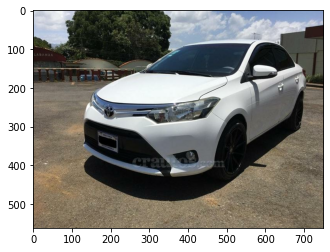

Imagen 2:


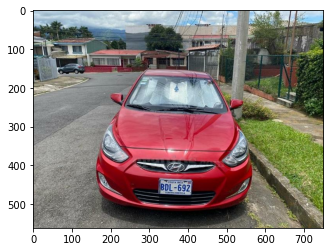

Imagen 3:


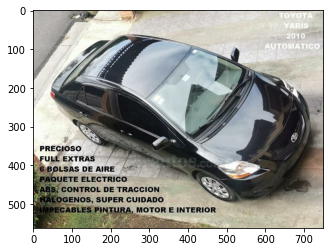

In [10]:
sample_df = df.sample(3)
for i, car in enumerate(sample_df.iterrows()):
    print("Imagen {}:".format(i+1))
    image_sample_text = tf.io.read_file(car[1][0])
    image_sample = tf.io.decode_jpeg(image_sample_text, channels=3)
    image_sample = tf.image.resize(decoded_image, [image_size, image_size])
    plt.imshow(image_sample)
    plt.show()
    if i == 2:
        break

**Fase 3: Preparacion de los datos**

**Division entre entrenamiento y prueba**

Se decide escoger el 10% de las muestras para validacion y pruebas del modelo.

In [11]:
train, test = train_test_split(df, test_size=TEST_SIZE)

Lectura de todas las imagenes a tensores:

In [12]:
X_train = tf.convert_to_tensor([get_image(car[1][0], IMAGE_SIZE) for car in train.iterrows()])
y_train = tf.convert_to_tensor([car[1][2] for car in train.iterrows()])

In [13]:
X_test = tf.convert_to_tensor([get_image(car[1][0], IMAGE_SIZE) for car in test.iterrows()])
y_test = tf.convert_to_tensor([car[1][2] for car in test.iterrows()])

Data Augmentation

In [24]:
trainAug = Sequential([
    preprocessing.Rescaling(scale=1.0 / 255),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    preprocessing.RandomRotation(0.3)])

testAug = Sequential([
    preprocessing.Rescaling(scale=1.0 / 255),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    preprocessing.RandomRotation(0.3)])

trainDS = tf.data.Dataset.from_tensor_slices((X_train, y_train))
testDS = tf.data.Dataset.from_tensor_slices((X_test, y_test))
trainDS = (
    trainDS
    .shuffle(50 * 100)
    .batch(50)
    .map(lambda x, y: (trainAug(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
testDS = (
    testDS
    .shuffle(50 * 100)
    .batch(50)
    .map(lambda x, y: (trainAug(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

**Fase 4: Modelado**

**Arquitectura de la Red Neuronal Convolucional**

In [15]:
# CNN Instance
cnn = tf.keras.models.Sequential()
# First Layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# Second Layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# Output Layer
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dropout(0.4))
cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(classes, activation='softmax'))

cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn.fit(trainDS, epochs=20, validation_data=testDS)

Epoch 1/20
20/20 [==============================] - 13s 625ms/step - loss: 1.4769 - accuracy: 0.3273 - val_loss: 1.3390 - val_accuracy: 0.3784
Epoch 2/20
20/20 [==============================] - 13s 620ms/step - loss: 1.3326 - accuracy: 0.3554 - val_loss: 1.3154 - val_accuracy: 0.4324
Epoch 3/20
20/20 [==============================] - 13s 616ms/step - loss: 1.3291 - accuracy: 0.3504 - val_loss: 1.3280 - val_accuracy: 0.4234
Epoch 4/20
20/20 [==============================] - 13s 618ms/step - loss: 1.3170 - accuracy: 0.3645 - val_loss: 1.2919 - val_accuracy: 0.4054
Epoch 5/20
20/20 [==============================] - 13s 619ms/step - loss: 1.3040 - accuracy: 0.3775 - val_loss: 1.2927 - val_accuracy: 0.4414
Epoch 6/20
20/20 [==============================] - 13s 616ms/step - loss: 1.2962 - accuracy: 0.3785 - val_loss: 1.2961 - val_accuracy: 0.4144
Epoch 7/20
20/20 [==============================] - 13s 625ms/step - loss: 1.2985 - accuracy: 0.3765 - val_loss: 1.3152 - val_accuracy: 0.4054

Los resultados de la red neuronal no son tan prometedores, lamentablemente a pesar de que la precision de entrenamiento sigue subiendo, la de validacion es inconsistente, lo que indica que el modelo se sobreajusta a el conjunto de datos de entrenamiento y no generaliza lo suficiente para predecir imagenes que no ha visto anteriormente.

Sin embargo, el modelo todavia se puede seguir mejorando, por ejemplo, limpiando mejor las imagenes antes de entrenar, o utilizando aprendizaje por transferencia con redes preentrenadas para detectar carros y especializarla para detectar modelos.

**Almacenamiento de resultados a .csv**

In [22]:
df_cnn = pd.DataFrame(cnn.history.history)
df_cnn.index += 1
df_cnn["Epochs"] = df_cnn.index
df_cnn.to_csv("cnn_results.csv", index=False)

**Evaluacion de resultados**

In [23]:
results_df = pd.read_csv("cnn_results.csv")
results_df

,Model ID,Prediction,Augmentation,Loss,Accuracy,Validation Loss,Validation Accuracy,Epochs
0,Prediction: Marca - Augmentation: No,Marca,No,1.518684,0.291097,1.541913,0.351293,1
1,Prediction: Marca - Augmentation: No,Marca,No,1.508752,0.296856,1.566002,0.237069,2
2,Prediction: Marca - Augmentation: No,Marca,No,1.497751,0.306215,1.527355,0.243534,3
3,Prediction: Marca - Augmentation: No,Marca,No,1.488906,0.320854,1.518124,0.357759,4
4,Prediction: Marca - Augmentation: No,Marca,No,1.476500,0.335253,1.554524,0.267241,5
...,...,...,...,...,...,...,...,...
195,Mejor,Marca y Modelo,Si,0.150687,0.945783,1.715293,0.477477,36
196,Mejor,Marca y Modelo,Si,0.116957,0.955823,1.674631,0.513514,37
197,Mejor,Marca y Modelo,Si,0.124980,0.956827,1.736413,0.504505,38
198,Mejor,Marca y Modelo,Si,0.120919,0.959839,1.841741,0.477477,39


Los resultados de la red neuronal no son tan prometedores, lamentablemente a pesar de que la precision de entrenamiento sigue subiendo, la de validacion es inconsistente, lo que indica que el modelo se sobreajusta a el conjunto de datos de entrenamiento y no generaliza lo suficiente para predecir imagenes que no ha visto anteriormente.

Sin embargo, el modelo todavia se puede seguir mejorando, por ejemplo, limpiando mejor las imagenes antes de entrenar, o utilizando aprendizaje por transferencia con redes preentrenadas para detectar carros y especializarla para detectar modelos.

**Mejoras a la red**

La red ahora va a leer de un directorio preparado con subfolders agrupados por el modelo del carro

In [25]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = r"C:\Users\lalej\Documents\images"

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1106 files belonging to 4 classes.
Using 885 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1106 files belonging to 4 classes.
Using 221 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['hondacivic', 'hyundaiaccent', 'nissanxtrail', 'toyotayaris']


In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

**Nueva arquitectura de la red**

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

La red ahora va a contener 4 capas ocultas 

In [34]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [35]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [36]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
28/28 [==============================] - 9s 325ms/step - loss: 1.3548 - accuracy: 0.3311 - val_loss: 1.3440 - val_accuracy: 0.3529
Epoch 2/10
28/28 [==============================] - 9s 312ms/step - loss: 1.3394 - accuracy: 0.3593 - val_loss: 1.3193 - val_accuracy: 0.3394
Epoch 3/10
28/28 [==============================] - 9s 319ms/step - loss: 1.3208 - accuracy: 0.3763 - val_loss: 1.2981 - val_accuracy: 0.3891
Epoch 4/10
28/28 [==============================] - 9s 310ms/step - loss: 1.2958 - accuracy: 0.3955 - val_loss: 1.2910 - val_accuracy: 0.3620
Epoch 5/10
28/28 [==============================] - 9s 316ms/step - loss: 1.2583 - accuracy: 0.4192 - val_loss: 1.2364 - val_accuracy: 0.4661
Epoch 6/10
28/28 [==============================] - 9s 313ms/step - loss: 1.2128 - accuracy: 0.4554 - val_loss: 1.2348 - val_accuracy: 0.4118
Epoch 7/10
28/28 [==============================] - 9s 311ms/step - loss: 1.1742 - accuracy: 0.4768 - val_loss: 1.2200 - val_accuracy: 0.4344
Epoch 

**Pruebas Reales**

Imagen 1:


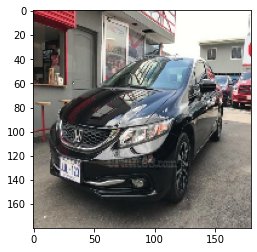

1/1 [==============================] - 0s 18ms/step
Honda Civic
Imagen 2:


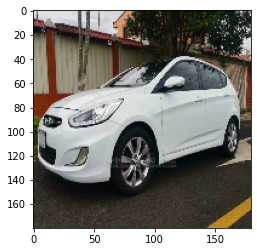

1/1 [==============================] - 0s 16ms/step
Toyota Yaris
Imagen 3:


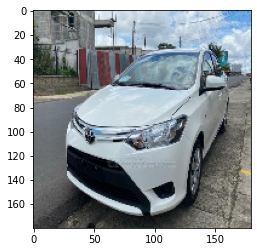

1/1 [==============================] - 0s 16ms/step
Toyota Yaris
Imagen 4:


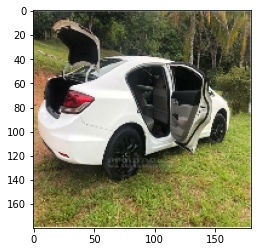

1/1 [==============================] - 0s 16ms/step
Toyota Yaris


In [55]:
sample_df = df.sample(3)
test_files = [r"C:\Users\lalej\Documents\images\hondacivic\0a87b82730064fddbabd0b38608b6dce.jpg",
              r"C:\Users\lalej\Documents\images\hyundaiaccent\4cfd055fa3bc4b8abe47021c47a726ed.jpg",
              r"C:\Users\lalej\Documents\images\toyotayaris\4fb01eb5ae444c5bb49e77070894fa27.jpg",
              r"C:\Users\lalej\Documents\images\hondacivic\00a381bf28de4af78f09570ac3db6afd.jpg",]
for i, car in enumerate(test_files):
    print("Imagen {}:".format(i+1))
    image_sample_text = tf.io.read_file(car)
    image_sample = tf.io.decode_jpeg(image_sample_text, channels=3)
    image_sample = tf.image.resize(image_sample, [img_height, img_height])
    image_sample = tf.cast(image_sample, np.uint8)
    plt.imshow(image_sample)
    plt.show()
    prediction = np.argmax(model.predict(tf.convert_to_tensor([image_sample])))
    if prediction == 0:
        print("Honda Civic")
    elif prediction == 0:
        print("Hyundai Accent")
    elif prediction == 0:
        print("Nissan Xtrail")
    else:
        print("Toyota Yaris")
#     if i == 0:
#         break

**Link al dashboard:**  
https://public.tableau.com/app/profile/luis.esquivel8695/viz/ProyectoFinal_16638330262630/ProyectoFinal?publish=yes 